Skipping 830 because it exists.
Skipping 833 because it exists.
Skipping 836 because it exists.
Skipping 839 because it exists.
Skipping 842 because it exists.
Doing 845.
Doing 848.


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/exfel/exp/HED/202101/p002621/proc/r0848'

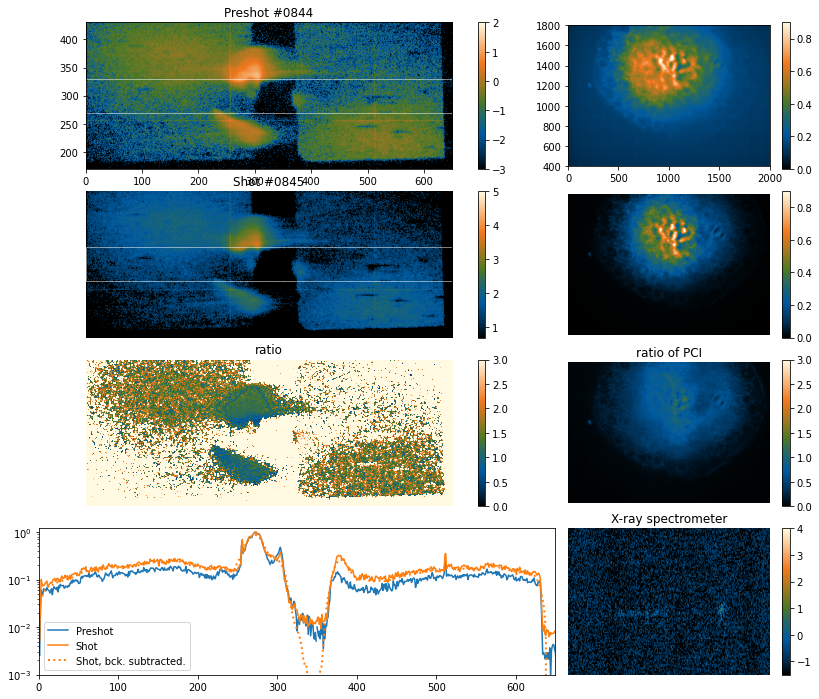

In [20]:
### %matplotlib notebook
# Script to show an overview of shot on 2621 Xfel.eu campaign
# Written dominantly by M.Šmíd, with acknowledgment to many contributing authors from HED/Hibef/HZDR during last years.
import os
import numpy as np
import scipy
from scipy import optimize, ndimage
import matplotlib.pyplot as plt
import extra_hed
from extra_data import open_run, RunDirectory, H5File
from matplotlib import gridspec
import extra_mmm as em
import mmmUtils as mu
import rossendorfer_farbenliste as rofl
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
proposal=2621
outDir='./overviews'  #Directory to store output images

runs=np.array([695,698,701,704,707,711,714,717,720,722,725,728,731,734,737,740])
runs=np.array([743,747,751,755,759,763])
runs=np.array([791,795,799,803,809,813])
runs=np.array([830,833,836,839,842,845,848])
runs=np.array([830,833,836,839,842,845,848])
#runs=np.array([668])
preshotoffset=1

debug=0
recalc=0
skipexisting=1
#SAXS setting:
    # day 0
rot=50   #rotation [°]
bl=200
br=250
line=628
w=8
axw=70
ax=[50,400,line-axw,line+axw]

    # day 1
rot=42   #rotation [°]
bl=150
br=250
line=620
w=14
axw=50
ax=[50,400,line-axw,line+axw]

    # day 3
foam=1
if foam:
    rot=0   #rotation [°]
    bl=350
    br=350
    line=300
    w=30
    axw=130
    ax=[50,470,line-axw,line+axw]
    ax=[0,650,line-axw,line+axw]
else:
    rot=42   #rotation [°]
    bl=350
    br=350
    line=400
    w=30
    axw=70
    ax=[200,700,line-axw,line+axw]
    

dat='proc'

suff=''



for runno in runs:
    preshotrun=runno-preshotoffset
    out_fn='shot_figs/ShotRR_{:04d}'.format(runno)+suff+'_preshot_{:04d}.jpg'.format(preshotrun)
    if skipexisting:
        if os.path.isfile(out_fn):
            print("Skipping {:.0f} because it exists.".format(runno))
            continue
    print("Doing {:.0f}.".format(runno))
    #preshotrun=-1
    suff=''
    #READ
    outDir='../overviews'
    if runno>-1:
        run = open_run(proposal, runno, data=dat)  #Opening the given run
        trainId=em.get_shot_trainId(run) #Getting the trainId when the laser was shot from IPM
        jf=em.get_image(run,runno,'JF3',trainId,debug=debug,recalc=recalc,threshold_lower=6)
        zyla=em.get_image(run,runno,'Zyla',trainId,debug=debug,recalc=recalc)
        if np.size(jf)==0:
            print("-there is no main shot Shot JF3")
            continue
        if not foam:
            jfb=np.transpose(jf)
        else:
            jfb=jf
        jfb[jfb<1]=1
    #preshot
    if preshotrun>-1:
        run_pre = open_run(proposal, preshotrun, data=dat)  #Opening the given run
#        trainId=-1
        pre_jf=em.get_image(run_pre,preshotrun,'JF3',-1,debug=debug,recalc=recalc,threshold_lower=6)
#        pre_zyla=em.get_image(run,runno,'Zyla',trainId,debug=debug,recalc=recalc)
        pre_zyla=em.get_image(run_pre,runno,'Zyla',-1,debug=debug,recalc=1,threshold_lower=6)
        if np.size(pre_jf)==0:
            print("-there is no preshot for JF3")
            continue
        if not foam:
            pre_jf=np.transpose(pre_jf)
        pre_jf[pre_jf<0.001]=0.001
        precnt=0
    #The bigger image:
    prer=ndimage.rotate(pre_jf, rot, reshape=True)
    prer[prer<0.001]=0.001
    shotr=ndimage.rotate(jfb, rot, reshape=True)
    shotr[shotr<1]=1

    #Picture including shot/preshot ratio
    if foam:
        plt.rcParams['figure.figsize'] = (14,12)
    else:
        plt.rcParams['figure.figsize'] = (14,10)
    fig=plt.figure()
    gs = gridspec.GridSpec(4, 3,hspace=0.15,wspace=0.05)

    ax0 = plt.subplot(gs[0,0:2])
    ax1 = plt.subplot(gs[0,2])
    ax2 = plt.subplot(gs[1,0:2])
    ax3 = plt.subplot(gs[1,2])
    ax4 = plt.subplot(gs[2,0:2])
    ax5 = plt.subplot(gs[2,2])
    ax6 = plt.subplot(gs[3,0:2])
    ax7 = plt.subplot(gs[3,2])
    
    rl=[line-w,line+w]
    rr=[line-w,line+w]
    ZylaClim=[0,0.9]
    if 1: #preshot SAXS
        plt.sca(ax0)
        plt.title('Preshot #{:04d}'.format(preshotrun,precnt))
        if np.size(pre_jf)>0:
            plt.imshow(np.log10(prer),cmap=rofl.cmap())
            plt.colorbar()
            plt.xlim(ax[0],ax[1])
            plt.ylim(ax[2],ax[3])
            plt.clim(-3,2)
            plt.plot([bl,0,0,bl],[rl[0],rl[0],rl[1],rl[1]],'w-',linewidth=0.5)    
            plt.plot([br,800,800,br],[rr[0],rr[0],rr[1],rr[1]],'w-',linewidth=0.5)    
            profs=shotr[rr[0]:rr[1],:]
            profs=np.mean(profs,0)
            profp=prer[rr[0]:rr[1],:]
            profp=np.mean(profp,0)
            profileratio=np.max(profs)/np.max(profp)
            profp=profp/np.max(profp)
            profs=profs/np.max(profs)
            plofs=shotr[rl[0]:rl[1],:]
            plofs=np.mean(plofs,0)
            plofp=prer[rl[0]:rl[1],:]
            plofp=np.mean(plofp,0)
            plofileratio=np.max(plofs)/np.max(plofp)
            plofp=plofp/np.max(plofp)
            plofs=plofs/np.max(plofs)
#            plt.axis('off')

    zax=[0,2000,400,1800]
    #zax=[0,3000,00,3000]
    dozyla=0
    if np.size(pre_zyla)>1: #preshot PCI Zyla
        plt.sca(ax1)
        pre_zyla=pre_zyla-100
        pre_zyla=mu.smooth2d(pre_zyla,7)
        pre_zyla=pre_zyla/np.max(pre_zyla)
        plt.imshow(pre_zyla,cmap=rofl.cmap())
        plt.colorbar()
        plt.axis(zax)
        plt.clim(ZylaClim) 
        dozyla=1

    if np.size(zyla)>1: #Shot PCI Zyla
        plt.sca(ax3)
        zyla=mu.smooth2d(zyla,3)-120
        zyla=zyla/np.max(zyla)
        plt.imshow(zyla,cmap=rofl.cmap())
        plt.colorbar()
        plt.axis(zax)
        plt.axis('off')
        plt.clim(ZylaClim)
        dozyla=dozyla+1

    if dozyla==2: #ratio of Zylas
        plt.sca(ax5)
        ratio=(zyla/pre_zyla)
        ratio[np.isinf(ratio)]=1
        plt.imshow(ratio,cmap=rofl.cmap())
        plt.colorbar()
        plt.axis(zax)
        plt.axis('off')
        plt.clim(0,3)
        plt.title('ratio of PCI')
    if 1:  #Spectrometer
        jf=em.get_image(run,runno,'JF1',trainId,debug=debug,recalc=recalc)
        if np.size(jf)>1:
            plt.sca(ax7)
            jf[jf<0.01]=0.01
            plt.imshow(np.log10(jf), cmap=rofl.cmap(),aspect='auto')
            plt.colorbar()
            plt.xlim(50,800)
            plt.ylim(370,470)
            plt.axis('off')
            plt.title("X-ray spectrometer")
#            plt.show()
            plt.clim(-1.5,4)
    if runno>-1: #main shot - saxs
        plt.sca(ax2)
        plt.imshow(np.log10(shotr),cmap=rofl.cmap())
        plt.colorbar()
        plt.xlim(ax[0],ax[1])
        plt.ylim(ax[2],ax[3])
        plt.clim(0.7,5)  #min vale 0.7 = log10(6) - i.e. single photon.
        plt.title('Shot #{:04d}'.format(runno)+suff)
        plt.axis('off')
        
        plt.plot([bl,0,0,bl],[rl[0],rl[0],rl[1],rl[1]],'w-',linewidth=0.5)    
        plt.plot([br,800,800,br],[rr[0],rr[0],rr[1],rr[1]],'w-',linewidth=0.5)    

    if 1: #ratio    
        plt.sca(ax4)
        ratio=(shotr/prer)
        ratio[np.isinf(ratio)]=1
        ratio=ratio/profileratio
        plt.imshow(ratio,cmap=rofl.cmap())
        plt.colorbar()
        plt.xlim(ax[0],ax[1])
        plt.ylim(ax[2],ax[3])
        plt.axis('off')
        plt.clim(0,3)
        plt.title('ratio'+suff,)
    #SAXS lineouts
    plt.sca(ax6)
    prx=np.arange(np.size(profp[br:-1]))+br
    prof2=mu.smooth(plofs,15)
    prof2min=np.min(prof2[10:620])
    prof2=prof2-prof2min
    #lefts
    pline=plt.semilogy(plofp[0:bl],label='Preshot')
    sline=plt.semilogy(plofs[0:bl],label='Shot')
    s2line=plt.semilogy(prof2[0:bl],':',color=sline[0].get_color(),label='Shot, bck. subtracted.',lw=2)
    #rights
    pline=plt.semilogy(prx,profp[br:-1],color=pline[0].get_color())
    plt.semilogy(prx,profs[br:-1],color=sline[0].get_color())
    plt.semilogy(prx,prof2[br:-1],':',color=sline[0].get_color(),lw=2)

    plt.legend()
    plt.ylim(1e-3,1.2)
    plt.xlim(0,650)
    #plt.title('Preshot #{:04d}, {:d} trains'.format(preshotrun,precnt))
#    plt.show()
    plt.savefig(out_fn,bbox_inches='tight')    

    